In [21]:

import torch
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
from datasets import load_dataset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

import os

In [22]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Define model paths (update these to your specific folder structure on Google Drive)
model_full_path = '/content/drive/MyDrive/model_full_finetuned'
model_lora_path = '/content/drive/MyDrive/model_lora_adapter'

# Check if models exist in the mounted Google Drive
if not os.path.exists(model_full_path):
    print("\\nERROR: ./model_full_finetuned/ not found!")
    print("Please download from: https://drive.google.com/drive/folders/1exOmAGt4iIYT3tBniyPrJHAzLbUnJLKy")
    exit(1)

if not os.path.exists(model_lora_path):
    print("\\nERROR: ./model_lora_adapter/ not found!")
    print("Please download from: https://drive.google.com/drive/folders/1G0PzrUMzjJ4ZNlyt_h_4X5t6X8fY0BK-")
    exit(1)


In [24]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Load tokenizer
print("\\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Load models
print("Loading Full Fine-tuned model...")
model_full = AutoModelForSequenceClassification.from_pretrained(
    model_full_path, num_labels=6
).to(device)

print("Loading LoRA adapter...")
base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6
).to(device)
model_lora = PeftModel.from_pretrained(base_model, model_lora_path)

print("\\nModels loaded successfully!")

Using device: cuda
\nLoading tokenizer...
Loading Full Fine-tuned model...
Loading LoRA adapter...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\nModels loaded successfully!


\nLoading test dataset...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Test examples: 1000
\nEvaluating Full Fine-tuning...
  Accuracy: 0.9400
\nEvaluating LoRA...
  Accuracy: 0.9350
\nGenerating visualizations...
Saved: confusion_matrices_reproduced.png
\n======================================================================
Full Fine-tuning Classification Report:
              precision    recall  f1-score   support

     sadness       0.95      0.98      0.96       255
         joy       0.96      0.95      0.96       367
        love       0.87      0.87      0.87        91
       anger       0.98      0.93      0.95       136
        fear       0.90      0.93      0.91       109
    surprise       0.85      0.81      0.83        42

    accuracy                           0.94      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.94      0.94      0.94      1000

\n======================================================================
LoRA Classification Report:
              precision    recall  f1-score   support

    

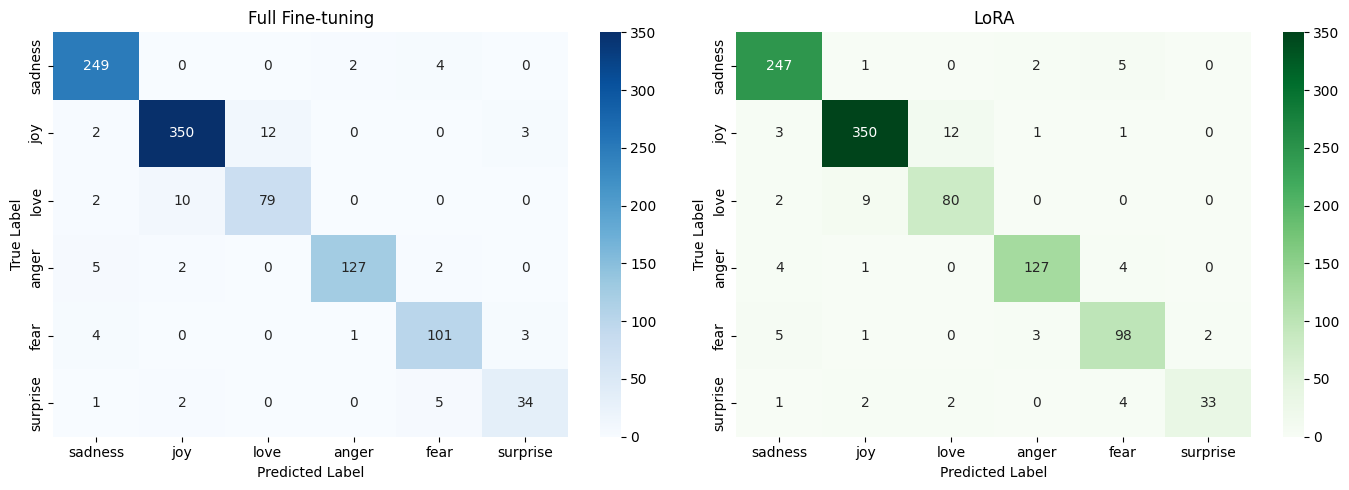

In [25]:


# Load test data
print("\\nLoading test dataset...")
dataset = load_dataset("emotion")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length",
                    truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
val_test = tokenized_datasets['validation'].train_test_split(test_size=0.5, seed=42)
test_dataset = val_test['test']

print(f"Test examples: {len(test_dataset)}")

# Evaluate function
def evaluate_model(model, dataset, model_name):
    model.eval()
    predictions = []
    true_labels = dataset['label']

    print(f"\\nEvaluating {model_name}...")
    for i in range(len(dataset)):
        inputs = tokenizer(dataset[i]['text'], return_tensors="pt",
                          truncation=True, max_length=128, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=-1).item()
            predictions.append(pred)

    # Calculate metrics
    accuracy = sum(p == t for p, t in zip(predictions, true_labels)) / len(true_labels)

    print(f"  Accuracy: {accuracy:.4f}")

    return predictions, true_labels

# Evaluate both models
preds_full, true_labels = evaluate_model(model_full, test_dataset, "Full Fine-tuning")
preds_lora, _ = evaluate_model(model_lora, test_dataset, "LoRA")

# Generate confusion matrices
print("\\nGenerating visualizations...")
cm_full = confusion_matrix(true_labels, preds_full)
cm_lora = confusion_matrix(true_labels, preds_lora)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, ax=axes[0])
axes[0].set_title('Full Fine-tuning')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_lora, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_names, yticklabels=label_names, ax=axes[1])
axes[1].set_title('LoRA')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices_reproduced.png', dpi=300)
print("Saved: confusion_matrices_reproduced.png")

# Classification reports
print("\\n" + "="*70)
print("Full Fine-tuning Classification Report:")
print("="*70)
print(classification_report(true_labels, preds_full, target_names=label_names))

print("\\n" + "="*70)
print("LoRA Classification Report:")
print("="*70)
print(classification_report(true_labels, preds_lora, target_names=label_names))


# Interactive demo
print("\n" + "="*70)
print("Interactive Demo - Test Your Own Sentences!")
print("="*70)
print("(Press Enter without text to exit)\n")

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True,
                      max_length=128, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Full FT
    model_full.eval()
    with torch.no_grad():
        outputs_full = model_full(**inputs)
        probs_full = torch.nn.functional.softmax(outputs_full.logits, dim=-1)[0]
        pred_full = torch.argmax(probs_full).item()

    # LoRA
    model_lora.eval()
    with torch.no_grad():
        outputs_lora = model_lora(**inputs)
        probs_lora = torch.nn.functional.softmax(outputs_lora.logits, dim=-1)[0]
        pred_lora = torch.argmax(probs_lora).item()

    print(f"\nText: \"{text}\"")
    print(f"Full FT: {label_names[pred_full].upper()} ({probs_full[pred_full]*100:.1f}%)")
    print(f"LoRA:    {label_names[pred_lora].upper()} ({probs_lora[pred_lora]*100:.1f}%)")
    if pred_full == pred_lora:
        print(f"Agreement: {label_names[pred_full].upper()}")
    else:
        print("Disagreement!")

# Test examples
examples = [
    "I'm so excited about this!",
    "I feel really sad and alone",
    "This makes me so angry!"
]

print("Example predictions:")
for ex in examples:
    predict_emotion(ex)




# More tests

## Longer texts

In [26]:
# Test examples
longexamples = [
    "I have been waiting for this moment for months, and now it is finally here! I cannot contain my excitement—everything just seems so perfect right now. I feel like I am on top of the world, and nothing could ruin my mood. The energy in the air is electrifying, and I cannot wait to see what happens next!",
    "Today, I had such a busy day at my internship. Work is piling up and I feel very anxious. Not to mention, there are so many upcoming examinations for school and I feel extremely unprepared. I have a vacation which I am really excited for and is looking forward to, however, it feels like the vacation is so far away. I am so close yet so far to the end of this semester. I feel like my health is declining. I will be really happy once I can catch a break.",
    "Last night, as I was lying in bed, I started thinking about the upcoming presentation at work. The anxiety hit me like a wave, and I couldn’t shake the feeling that something would go horribly wrong. I started imagining all the worst-case scenarios: forgetting my lines, technical difficulties, or worst of all, having people laugh at my ideas. The more I thought about it, the more nervous I became. My heart started racing, my palms got sweaty, and it felt like I couldn’t breathe properly. Even though I tried to calm myself down, the fear kept growing. It’s not the first time I’ve felt this way before a big event, but it never gets easier. I kept telling myself that everything would be fine, but the fear still wouldn’t let go.",
    "yesterday was one of those rare days where everything felt like they all fell into place. I woke up early and felt major gratitude for everything I have been blessed with. For the first time in a long while, I felt completely at peace.There was a lightness in the air, a sense of freedom that I haven’t felt in a long time. By the time I got home, I had this warm feeling in my chest, like everything was right in the world. I took in the world around me and it felt like nothing in this world can bring me down. I was present in the moment and took a deep breathe, taking time to savour and smell the roses and the fresh air around me. It felt like the sky was so clear, my skin was glowing, the weather was not too cold, not too humid"
]

print("\nTesting examples:")
for ex in longexamples:
    predict_emotion(ex)



Testing examples:

Text: "I have been waiting for this moment for months, and now it is finally here! I cannot contain my excitement—everything just seems so perfect right now. I feel like I am on top of the world, and nothing could ruin my mood. The energy in the air is electrifying, and I cannot wait to see what happens next!"
Full FT: JOY (99.9%)
LoRA:    JOY (99.4%)
Agreement: JOY

Text: "Today, I had such a busy day at my internship. Work is piling up and I feel very anxious. Not to mention, there are so many upcoming examinations for school and I feel extremely unprepared. I have a vacation which I am really excited for and is looking forward to, however, it feels like the vacation is so far away. I am so close yet so far to the end of this semester. I feel like my health is declining. I will be really happy once I can catch a break."
Full FT: FEAR (99.8%)
LoRA:    FEAR (98.9%)
Agreement: FEAR

Text: "Last night, as I was lying in bed, I started thinking about the upcoming prese

##  Texts with contradicting emotions

In [27]:
contradictingexamples = [
  "Yesterday, I was overjoyed about my promotion at work, but my excitement quickly turned to frustration when I found out that I had to handle more responsibility without any additional support from the team"
  , "When I opened the door yesterday, I was surprised to find a package I wasn’t expecting. But then, as I opened it, I started feeling anxious about what might be inside. what if it was something important I had missed?",
  "I felt a deep sadness yesterday when I realized how much I miss my family. Even though I love them and they love me, the distance has created an aching feeling that I can’t seem to shake."

  ]


print("\nTesting examples:")
for ex in contradictingexamples:
    predict_emotion(ex)




Testing examples:

Text: "Yesterday, I was overjoyed about my promotion at work, but my excitement quickly turned to frustration when I found out that I had to handle more responsibility without any additional support from the team"
Full FT: JOY (99.6%)
LoRA:    JOY (94.2%)
Agreement: JOY

Text: "When I opened the door yesterday, I was surprised to find a package I wasn’t expecting. But then, as I opened it, I started feeling anxious about what might be inside. what if it was something important I had missed?"
Full FT: FEAR (99.8%)
LoRA:    FEAR (97.9%)
Agreement: FEAR

Text: "I felt a deep sadness yesterday when I realized how much I miss my family. Even though I love them and they love me, the distance has created an aching feeling that I can’t seem to shake."
Full FT: SADNESS (99.9%)
LoRA:    SADNESS (95.2%)
Agreement: SADNESS


##  Texts with irony

In [28]:
ironicexamples = [
  "lol, it's okay, I wasn't planning on sleeping anyways. Who needs sleep when there are deadlines to meet?",
  "I’m absolutely thrilled to handle this impossible task you just dropped on my lap",
  "Oh great! another teams message I didn’t ask for. And right when I was planning to leave the office. Just what I needed to brighten my day."

  ]


print("\nTesting examples:")
for ex in ironicexamples:
    predict_emotion(ex)


Testing examples:

Text: "lol, it's okay, I wasn't planning on sleeping anyways. Who needs sleep when there are deadlines to meet?"
Full FT: JOY (62.7%)
LoRA:    JOY (42.7%)
Agreement: JOY

Text: "I’m absolutely thrilled to handle this impossible task you just dropped on my lap"
Full FT: JOY (99.9%)
LoRA:    JOY (99.6%)
Agreement: JOY

Text: "Oh great! another teams message I didn’t ask for. And right when I was planning to leave the office. Just what I needed to brighten my day."
Full FT: JOY (98.5%)
LoRA:    JOY (97.5%)
Agreement: JOY


##  Assigning emotions to DSM-5 Diagnosis Criterias

In [29]:
dsm5examples = [
  "Depressed mood most of the day, nearly every day; markedly diminished interest or pleasure in all or almost all activities; significant weight loss or weight gain; insomnia or excessive sleeping; fatigue or loss of energy; feelings of worthlessness or excessive guilt; diminished ability to think or concentrate, or indecisiveness; thoughts of death or suicide, or suicide attempts.",
  "Excessive worry occurring more days than not for at least six months; difficulty controlling the worry; restlessness or feeling on edge; easily fatigued; difficulty concentrating or mind going blank; irritability; muscle tension; sleep disturbance.",
  "Restricting food intake leading to significantly low body weight (Anorexia); recurrent episodes of binge eating followed by inappropriate compensatory behaviors (Bulimia); extreme concern about body image and weight; distorted perception of weight or body size.",
  "Persistent pattern of inattention and/or hyperactivity-impulsivity that interferes with functioning or development; difficulty focusing on tasks, forgetfulness, impulsivity, restlessness, and a lack of organization."

  ]


print("\nTesting examples:")
for ex in dsm5examples:
    predict_emotion(ex)


Testing examples:

Text: "Depressed mood most of the day, nearly every day; markedly diminished interest or pleasure in all or almost all activities; significant weight loss or weight gain; insomnia or excessive sleeping; fatigue or loss of energy; feelings of worthlessness or excessive guilt; diminished ability to think or concentrate, or indecisiveness; thoughts of death or suicide, or suicide attempts."
Full FT: SADNESS (99.9%)
LoRA:    SADNESS (99.9%)
Agreement: SADNESS

Text: "Excessive worry occurring more days than not for at least six months; difficulty controlling the worry; restlessness or feeling on edge; easily fatigued; difficulty concentrating or mind going blank; irritability; muscle tension; sleep disturbance."
Full FT: SADNESS (92.9%)
LoRA:    FEAR (84.2%)
Disagreement!

Text: "Restricting food intake leading to significantly low body weight (Anorexia); recurrent episodes of binge eating followed by inappropriate compensatory behaviors (Bulimia); extreme concern about

# Interactive demo

Type in sentence.

Press enter to exit

In [30]:
print("\nYour turn! Type sentences to classify:")
while True:
    text = input("\nSentence: ").strip()
    if not text:
        break
    predict_emotion(text)

print("\n" + "="*70)
print("Demo complete!")
print("="*70)


Your turn! Type sentences to classify:

Sentence: 

Demo complete!
